Adapted from code by Aneesha Bakharia [here](https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229)

In [45]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
warnings.filterwarnings(action='ignore', category=FutureWarning, module='gensim' )
import gensim
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models.fasttext import FastText as FT_gensim
%matplotlib inline
import pandas as pd
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider, LabelSet
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()

Loading BokehJS ...

In [2]:
model = FT_gensim.load("model/model_cuneiform.model")

In [3]:
with open("output/ogsl.p", "rb") as p:
    o = pickle.load(p)
d = dict(zip(o["value"], o["utf8"]))

In [4]:
def cun(text): 
    """transform transliterated input into cuneiform. Use unicode subscript numbers and separate all signs with hyphens; separate words with blanks
    Examples: 'ma-an-gi₄'; 'd-en-lil₂ nibru-ki'.
    Transliteration style (sugal₇ vs. sukkal; dug₄ vs. du₁₁; gen vs. ŋen; etc.) and capitalization are unimportant.
    """
    cun_line = []
    words = text.lower().split()
    for word in words: 
        signs = word.lower().split('-')
        seq = [d[s] if s in d else s for s in signs]
        seq = ''.join(seq)
        cun_line.append(seq)
    line = ' '.join(cun_line)
    return(line)

In [11]:
def tsne_plot(model, words, cun=False, fontsize=12):
    "Creates a TSNE model and plots it"
    "adapted from https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne"
    """model is a word embedding model. 
    The variable words is a dictionary of words taken from the model; the value
    of each word is a category label, an integer between 0 and 5"""
    if cun:
        cunfont = {'fontname':'CuneiformOB'}
    else:
        cunfont = {'fontname' : 'DejaVu'}
    labels = []
    tokens = []
    categories = []
    
    for word in words:
        tokens.append(model.wv[word])
        labels.append(word)
        categories.append(words[word])
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    color_d = {0: "black", 1: "green", 2: "blue", 3: "red", 4: "yellow", 5: "brown"}
    
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.plot(x[i],y[i], 'o', color="black")
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     **cunfont,
                     fontsize=fontsize,
                     color = color_d[categories[i]])
    plt.show()

In [12]:
def word_categories(model, words, topn=10):
    """word_categories takes an iterable with one or more words from the vocabulary of model.
    For each word a dictionary of similar words (with the target word) is construed.
    The value of each word is numerical (integer) and indicates the category to which it belongs.
    The function returns a dictionary."""
    word_d = {}
    for idx, word in enumerate(words):
        w = model.wv.most_similar(word, topn=topn)
        w = [m[0] for m in w]
        w.append(word)
        for item in w:
            word_d[item] = idx
    return word_d

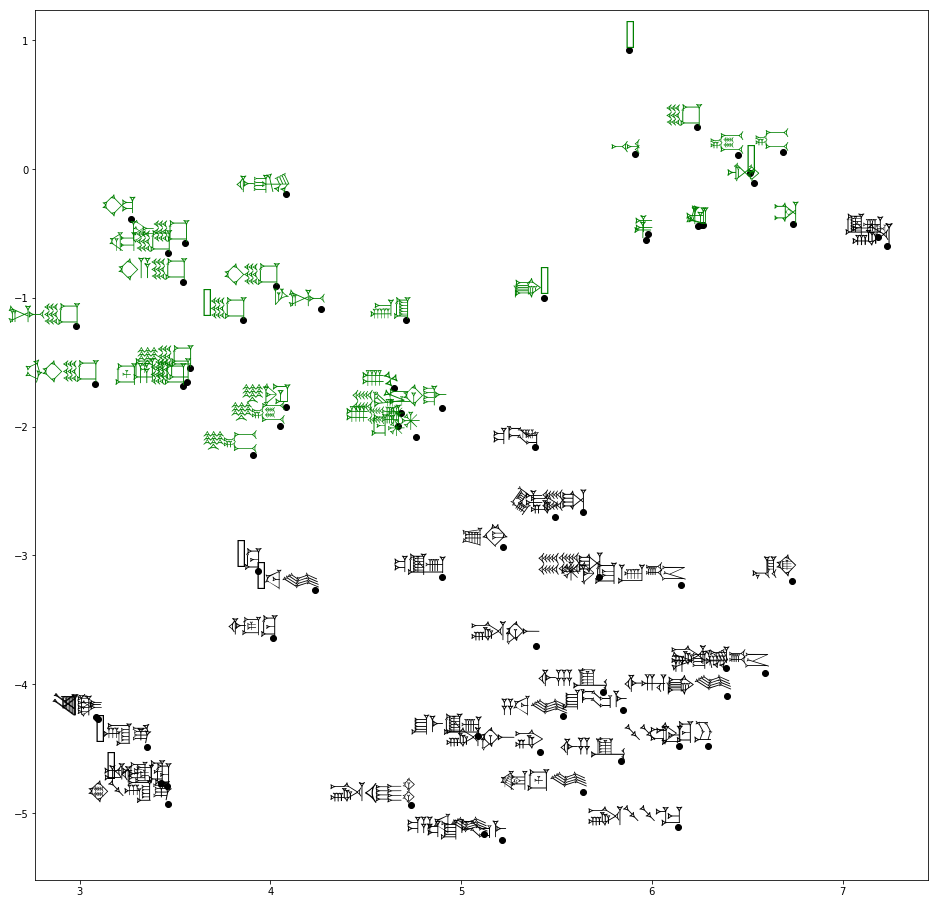

In [13]:
words_d = word_categories(model, [cun("šim-gig"), cun("hi-sar")], 35)
tsne_plot(model, words_d, True, 20)

In [8]:
model2 = FT_gensim.load("model/model_lemm.model")

In [65]:
words_d = word_categories(model, [cun("šim-gig"), cun("hi-sar")], 35)

labels = []
tokens = []
categories = []
    
for word in words_d:
    tokens.append(model.wv[word])
    labels.append(word)
    categories.append(words_d[word])
    
color_d = {0: "black", 1: "red", 2: "blue", 3: "green", 4: "yellow", 5: "brown"}
colors = [color_d[category] for category in categories]

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_embedding = tsne.fit_transform(tokens)
tsne_embedding = pd.DataFrame(tsne_embedding, columns=['x','y'])
tsne_embedding["color"] = colors
tsne_embedding["labels"] = labels
source = ColumnDataSource(
    data=dict(
        x = tsne_embedding.x,
        y = tsne_embedding.y,
        colors = tsne_embedding.color,
        labels=tsne_embedding.labels
        )
    )
l = LabelSet(x='x', y='y', text='labels', level='glyph',
              x_offset=5, y_offset=5, source=source, render_mode='canvas', 
             text_font_size="10pt", text_font="CuneiformComposite")

plot_tsne = figure(plot_width=900, plot_height=900) #, tools=tools_tsne, title='Papers')
plot_tsne.circle('x', 'y', size=7, fill_color='colors', 
                  line_alpha=0, line_width=0.01, source=source)
plot_tsne.add_layout(l)
layout = column(plot_tsne)
show(layout)